Load the data
---

Channels: 1
Frame Length: 1440000
Sample Width: 3
Frame Rate 48000
Channels: 1
Frame Length: 1440000
Sample Width: 3
Frame Rate 48000
(1440000, 1)
(1440000, 1)


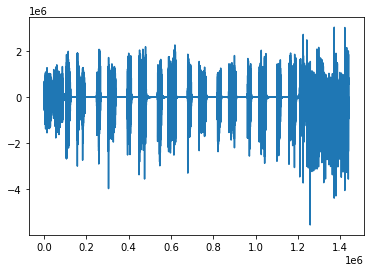

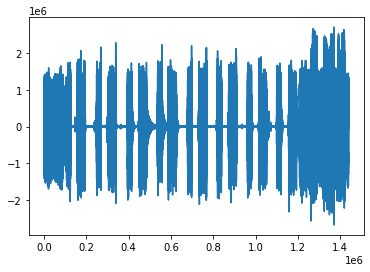

In [1]:
from wav_loader import wav_to_np
from wav_visualizer import draw_file

source_file = 'data/split_30_essex30_source.wav'
target_file = 'data/split_30_essex30_amp_ir.wav'

source = wav_to_np(source_file)
target = wav_to_np(target_file)
print(source.shape)
print(target.shape)

draw_file(source)
draw_file(target)

Preprocess Data
---

In [2]:
# Normalize between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler((0,1))
source_normalized = scalar.fit_transform(source)
target_normalized = scalar.fit_transform(target)

Split Dataset
---

In [3]:
total_size = len(source)
test_size = 1000
train_size = total_size - test_size
print(train_size, test_size)

source_train = source_normalized[:train_size, :]
target_train = target_normalized[:train_size, :]

source_test = source_normalized[train_size:, :]
target_test = source_normalized[train_size:, :]

print(source_train.shape, target_train.shape)
print(source_test.shape, target_test.shape)

1439000 1000
(1439000, 1) (1439000, 1)
(1000, 1) (1000, 1)


Create the RNN dataset
---
Dataset will contain the previous 25 samples as 'lookback'


In [4]:
from dataset_creation import create_dataset
# Lookback past 25 samples
lookback = 25

(X_train, y_train) = create_dataset(source_train, target_train, lookback)
(X_test, y_test) = create_dataset(source_test, target_test, lookback)

In [5]:
# Reshape the data
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1438974, 1, 25) (1438974,)
(974, 1, 25) (974,)


Create the Model
---

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

tf.random.set_seed(3)

#Create a Keras Model
model = Sequential()
#Add LSTM
model.add(LSTM(32, input_shape=(1,lookback)))
model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                7424      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


Train!
---

In [8]:
epochs = 5
batch_size = 1
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
print(history.history)

Epoch 1/4
  28006/1438974 [..............................] - ETA: 3:44:12 - loss: 0.0083 - mse: 0.0083

KeyboardInterrupt: 

Test
---

In [ ]:
#Evaluate the model
result = model.evaluate(X_test, y_test, verbose=1)

#Predict on the test dataset
predictions = model.predict(X_test)

#Inverse the scaling to view results
predictions = scalar.inverse_transform(predictions)

Visualize Results
---

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, label='Target')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()